# Literature analysis (subsection 3.1 of the manuscript)

In [1]:
import warnings

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib_venn import venn2
from rdkit import Chem

# Filter the reference down to compounds with plausible exact mass.
# This approach calculates a set of plausible exact masses based on possible
# adduct forms and then quickly looks up the corresponding reference indices
# via mass discretization and bucket lookups.
from spectral_inference_zoo.library_search.mass_filtering import MassFilter

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
DATA_DIR = "../data"
FIGURE_DIR = "../figures"

In [3]:
sns.set_style(style="ticks")
sns.set_context(context="talk")

Load data

In [4]:
literature_df = pd.read_csv(
    f"{DATA_DIR}/processed/public_ref.tsv.gz",
    sep="\t",
    compression="gzip",
)

In [5]:
literature_df.head(2)

,plant,smiles,source,mapped_curie,mapped_plant,inchikey14,scaffold
0,Kalanchoe daigremontiana,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,lotus,ncbitaxon:23013,Bryophyllum daigremontianum,HVYWMOMLDIMFJA,C1=C2CCCCC2C2CCC3CCCC3C2C1
1,Kalanchoe daigremontiana,CCC(CCC(C)C1CCC2C3CC=C4CC(OC(C)=O)CCC4(C)C3CCC...,lotus,ncbitaxon:23013,Bryophyllum daigremontianum,PBWOIPCULUXTNY,C1=C2CCCCC2C2CCC3CCCC3C2C1


In [6]:
literature_df.inchikey14.nunique(), literature_df.mapped_curie.nunique()

(124086, 32442)

In [7]:
smiles_counts = literature_df["smiles"].value_counts().values
curie_counts = literature_df["mapped_curie"].value_counts().values

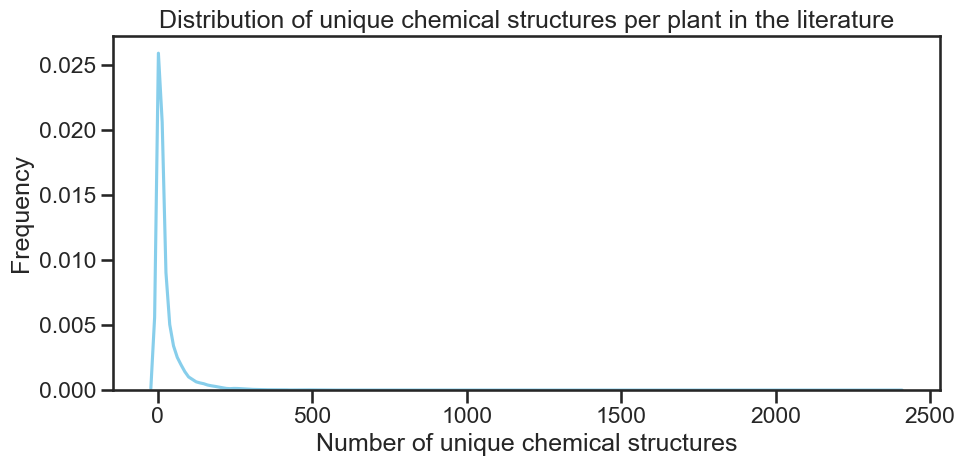

In [8]:
plt.figure(figsize=(10, 5))

sns.kdeplot(
    curie_counts,
    color="skyblue",
)

# add Y labels
plt.ylabel("Frequency")
plt.xlabel("Number of unique chemical structures")

plt.title("Distribution of unique chemical structures per plant in the literature")

plt.tight_layout()

plt.savefig(f"{FIGURE_DIR}/literature_unique_chemical_structures.png", dpi=400)

plt.show()

# Cumulative counts

In [9]:
# make a dictinoary from the plant_id to a set of ms2mol_smiles
plant_structures = (
    literature_df.groupby("mapped_curie")["inchikey14"].apply(set).to_dict()
)
# do the same for murcko scaffolds
plant_structures_scaffold = (
    literature_df.groupby("mapped_curie")["scaffold"].apply(set).to_dict()
)

In [10]:
# Cumulatively calculate the number of unique structures

counts = []
counts_scaffold = []

current_set = set()
current_set_scaffold = set()

# for each plant
for plant in plant_structures:
    # get its smiles
    smiles = plant_structures[plant]

    # and update the cumulative set
    current_set.update(smiles)
    # store the length of the cumulative set
    counts.append(len(current_set))

    # do the same for the scaffolds
    scaffold = plant_structures_scaffold[plant]
    current_set_scaffold.update(scaffold)
    counts_scaffold.append(len(current_set_scaffold))

In [11]:
# verify that the cumulative sum is equal to the number of unique structures
assert (
    len(current_set) == literature_df.inchikey14.nunique()
), "The final set of structures in the cumulative sum should be equal to the number of unique structures in the dataset"

In [12]:
# Create a dataframe with the number of unique structures
compounds_in_plant = (
    literature_df.groupby("mapped_curie")
    .count()
    .reset_index()[["mapped_curie", "inchikey14"]]
)

In [13]:
# Add the counts to the dataframe
compounds_in_plant["cumulative_structures"] = counts
compounds_in_plant["cumulative_scaffolds"] = counts_scaffold

# replace every mapped_curie with a number from 1 to the number of unique plants
compounds_in_plant["mapped_curie"] = compounds_in_plant["mapped_curie"].factorize()[0]

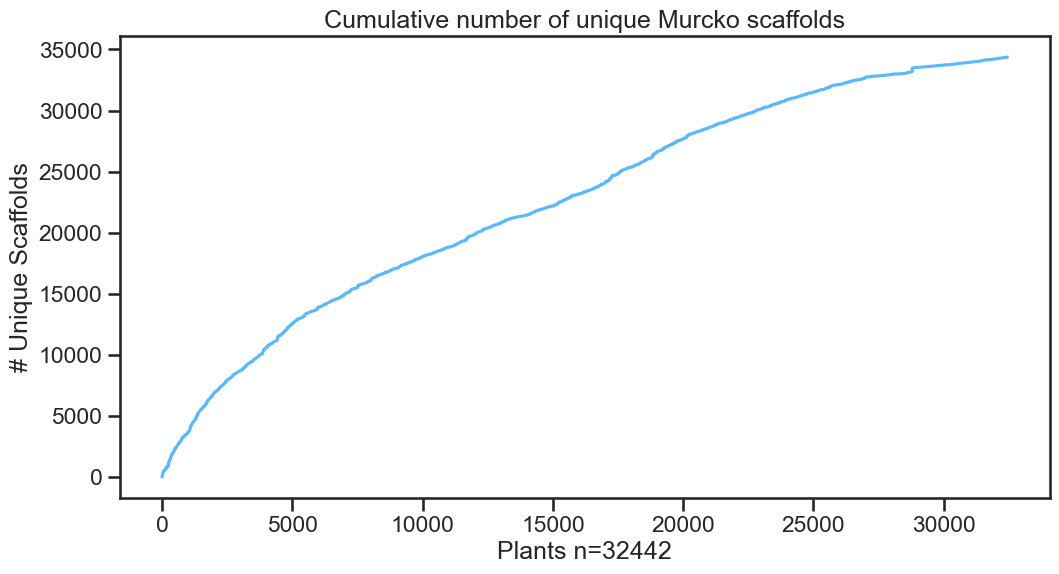

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    y="cumulative_scaffolds",
    x="mapped_curie",
    data=compounds_in_plant,
    ax=ax,
    color="#5cb9fc",
)

ax.set_title("Cumulative number of unique Murcko scaffolds")
ax.set_xlabel(f"Plants n={compounds_in_plant.mapped_curie.nunique()}")
ax.set_ylabel("# Unique Scaffolds")

plt.savefig("../figures/literature_murcko_curve.png", dpi=400)

plt.show()

In [15]:
# ratio between the number of unique structures and the number of unique scaffolds

literature_df.inchikey14.nunique() / literature_df.scaffold.nunique()

3.610194640830933

## Overlay Literature with the metabolomics data (ENPKG)

We now want to see how much the metabolomics data overlaps with the literature data.
This will give us an idea of how much the metabolomics data is missing since ideally we identify all the literature metabolites in the metabolomics data.

First, we load the data from the ENPKG database to overlay it with the literature data.

In [16]:
# This file can be generated in 1_data_stats.ipynb in the same way that
# enpkg_m+h+only_with_ms_data.pq is generated without using the M+H adduct filter
enpkg_df = pd.read_parquet(
    f"{DATA_DIR}/raw/enpkg_with_ms_data.pq",
)
enpkg_df.head(2)

,inchikey,smiles,adduct,feature_id,confidence_score,wikidata_species_id,?massive_id,row_uid,library_massive_id_x,type_by_confidence (t=0.5),...,retention_time,ms_level,precursor_mz,mz_list,i_list,library_massive_id_y,file_name,merged_stats,massive_id,dataset
0,KAHZQJKLALFAGB,CC(CCC(=O)O)C1CCC2C1(CCC3C2C(C(C4C3(CC(C(C4)O)...,[M+H]+,lcms_feature_mzspec:MSV000093464:KP072_Positiv...,0.096916,Q715019,<https://massive.ucsd.edu/ProteoSAFe/dataset.j...,id_0,MSV000093464,unknown,...,825.628,2,425.2877,"[114.2855, 123.1167, 129.5749, 130.5267, 131.0...","[20.0, 30.0, 49.0, 67.0, 47.0, 43.0, 49.0, 29....",MSV000093464,KP072_Positive_features_ms2_pos.mgf,None,lcms_feature_mzspec:MSV000093464:KP072_Positiv...,MSV000093464
1,LSUXCWJOIAWGOU,CCCCCC=CCC=CCCCCCCCC(=O)OC(CO)COP(=O)(O)OCC[N+...,[M+H]+,lcms_feature_mzspec:MSV000093464:KP072_Positiv...,0.227740,Q715019,<https://massive.ucsd.edu/ProteoSAFe/dataset.j...,id_1,MSV000093464,unknown,...,613.767,2,520.3414,"[99.9537, 104.1092, 104.1143, 115.0859, 115.36...","[38.0, 21.0, 48.0, 24.0, 26.0, 42.0, 68.0, 310...",MSV000093464,KP072_Positive_features_ms2_pos.mgf,None,lcms_feature_mzspec:MSV000093464:KP072_Positiv...,MSV000093464


In [17]:
# Get number of spectra with 90% of intensity in one peak
maxs = enpkg_df.i_list.apply(lambda x: max(x))
sums = enpkg_df.i_list.apply(lambda x: sum(x))
max_percentage_intensity = ((maxs / sums) > 0.9).mean()

print(
    "Percentage of spectra with highest intensity peak accounting for more than 90% of total intensity: ",
    max_percentage_intensity,
)

Percentage of spectra with highest intensity peak accounting for more than 90% of total intensity:  0.010441980219275622


To overlay it, we first need to see which plants are in both datasets.
To do that we will map the WikiData QID to plant curie identifiers, similar to what we did in the literature.

In [18]:
wikidata_df = pd.read_csv(
    f"{DATA_DIR}/processed/wikidata_ids_to_plant_names.csv",
)[["ID", "mapped_curie"]]

# get a dict between ID and mapped_curie
wikidata_dict = wikidata_df.set_index("ID")["mapped_curie"].to_dict()

# add a new col with the mapped curie to the ms2_data
enpkg_df["mapped_curie"] = enpkg_df["wikidata_species_id"].map(wikidata_dict)

del wikidata_df

In total 705 plants are in both datasets.

In [19]:
plants_in_both_datasets = set(literature_df.mapped_curie.unique()).intersection(
    set(enpkg_df.mapped_curie.unique())
)

print(len(plants_in_both_datasets))

705


In [20]:
# Subset both datasets to the plants in both datasets
literature_subset_in_enpkg = literature_df[
    literature_df["mapped_curie"].isin(plants_in_both_datasets)
]
enpkg_df_subset = enpkg_df[enpkg_df["mapped_curie"].isin(plants_in_both_datasets)]

Now, we have to remove from the literature, any structure that was not part of the reference library in the ENPKG dataset, since that structure could not have been identified.

Since ENPKG used BIODB as a reference library, we load the library and subset the literature data on it.

In [21]:
# To download biodb, please contact the SIRIUS team, as it requires a license
# See: https://boecker-lab.github.io/docs.sirius.github.io/prerequisites/

biodb = pd.read_csv(
    f"{DATA_DIR}/processed/raw/bio_2023_07_11_smiles.csv.gz",
    compression="gzip",
)

# Get all inchikeys in the bio db
biodb_inchikey = biodb["inchi_key_1"].unique()

In [22]:
# now subset literature to inchikeys in biodb
literature_subset_in_enpkg_and_in_biodb = literature_subset_in_enpkg[
    literature_subset_in_enpkg["inchikey14"].isin(biodb_inchikey)
]

print(
    f"Literature before filtering by BioDB: {literature_subset_in_enpkg.shape[0]}, after: {literature_subset_in_enpkg_and_in_biodb.shape[0]}"
)

enpkg_df_subset_confident = enpkg_df_subset[
    enpkg_df_subset["type_by_confidence (t=0.5)"] == "known"
]

Literature before filtering by BioDB: 90892, after: 89496


Let's plot the raw overlap by looking at chemical structures

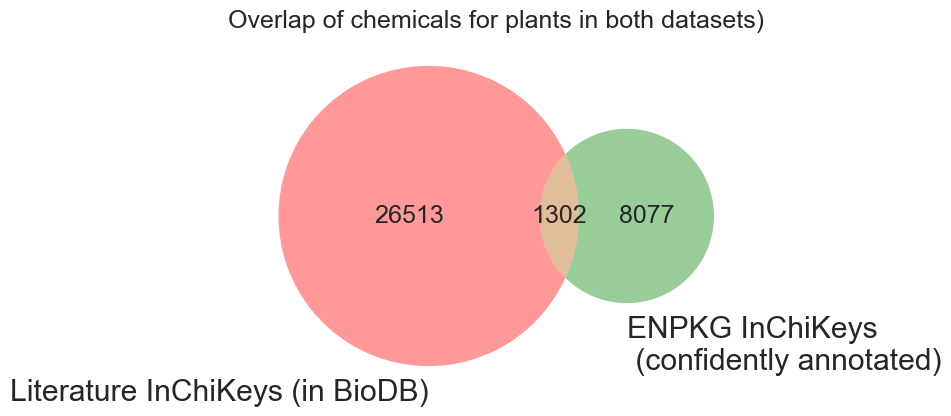

In [23]:
venn2(
    subsets=[
        set(literature_subset_in_enpkg_and_in_biodb.inchikey14.unique()),
        set(enpkg_df_subset_confident.inchikey.unique()),
    ],
    set_labels=(
        "Literature InChiKeys (in BioDB)",
        "ENPKG InChiKeys\n (confidently annotated)",
    ),
)

plt.title("Overlap of chemicals for plants in both datasets)")

plt.show()

#### See the overlap at the MS1 level between the literature and the ENPKG data 

In [24]:
plant_overlap = []

for plant in tqdm(plants_in_both_datasets):

    literature_this_plant = literature_subset_in_enpkg_and_in_biodb[
        literature_subset_in_enpkg_and_in_biodb["mapped_curie"] == plant
    ]

    # get the masses of the literature smiles with rdkit
    literature_this_plant["exact_mass"] = [
        Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smiles))
        for smiles in literature_this_plant["smiles"]
    ]

    # Remove literature compounds with mass less than 120 (e.g water and stuff that is going to
    # artificially increase the number of matches)
    literature_this_plant = literature_this_plant[
        literature_this_plant["exact_mass"] > 120
    ]

    literature_this_plant = literature_this_plant[["exact_mass"]].drop_duplicates()

    enpkg_this_plant = enpkg_df_subset[enpkg_df_subset["mapped_curie"] == plant]

    if enpkg_this_plant.empty or literature_this_plant.empty:
        continue

    enpkg_this_plant.loc[:, "ion_mode"] = enpkg_this_plant["charge"].apply(
        lambda x: "positive" if x > 0 else "negative"
    )
    enpkg_this_plant = enpkg_this_plant[["precursor_mz", "ion_mode"]]

    if literature_this_plant.shape[0] < 20:
        continue

    mass_filter = MassFilter(
        ref_mass_col="exact_mass",  # these are the masses from the known compounds in the literature
        query_precursor_mz_col="precursor_mz",
        query_ion_mode_col="ion_mode",
        candidate_adducts=[
            "[M+H]+",
            "[M+K]+",
            "[M+H3N+H]+",
            "[M-H2O+H]+",
            "[M-H4O2+H]+",
            "[M-H]-",
            "[M+Cl]-",
            "[M-H2O-H]-",
            "[M+CH2O2-H]-",
        ],
        tol=0.05,
        strict_filter=True,
    )

    mass_filter.prepare(
        reference_df=literature_this_plant,
    )

    result_array = mass_filter(
        query=enpkg_this_plant,
    )

    # Check if the numpy array is empty
    if not result_array:
        continue

    all_literature_matches = set()

    for query in result_array:
        all_literature_matches.update(set(query))

    # print(
    #     f"Ratio matches for {plant}: {len(all_literature_matches)/literature_this_plant.shape[0]}"
    # )
    plant_overlap.append(
        {
            "plant": plant,
            "ms2_matches": len(result_array),
            "literature_compounds": literature_this_plant.shape[0],
            "ratio": (len(all_literature_matches) / literature_this_plant.shape[0])
            * 100,
        }
    )

    # if plant == "ncbitaxon:94328":
    #     break

plant_overlap_df = pd.DataFrame(plant_overlap)

100%|██████████| 705/705 [00:23<00:00, 30.18it/s]


In [25]:
plant_overlap_df

,plant,ms2_matches,literature_compounds,ratio
0,ncbitaxon:199225,163,130,26.923077
1,ncbitaxon:577683,334,43,37.209302
2,ncbitaxon:4378,684,59,57.627119
3,ncbitaxon:174651,7,33,0.000000
4,ncbitaxon:1277777,199,44,43.181818
...,...,...,...,...
485,ncbitaxon:260718,432,22,9.090909
486,ncbitaxon:396367,60,167,14.371257
487,ncbitaxon:174652,104,58,25.862069
488,ncbitaxon:655181,92,38,55.263158


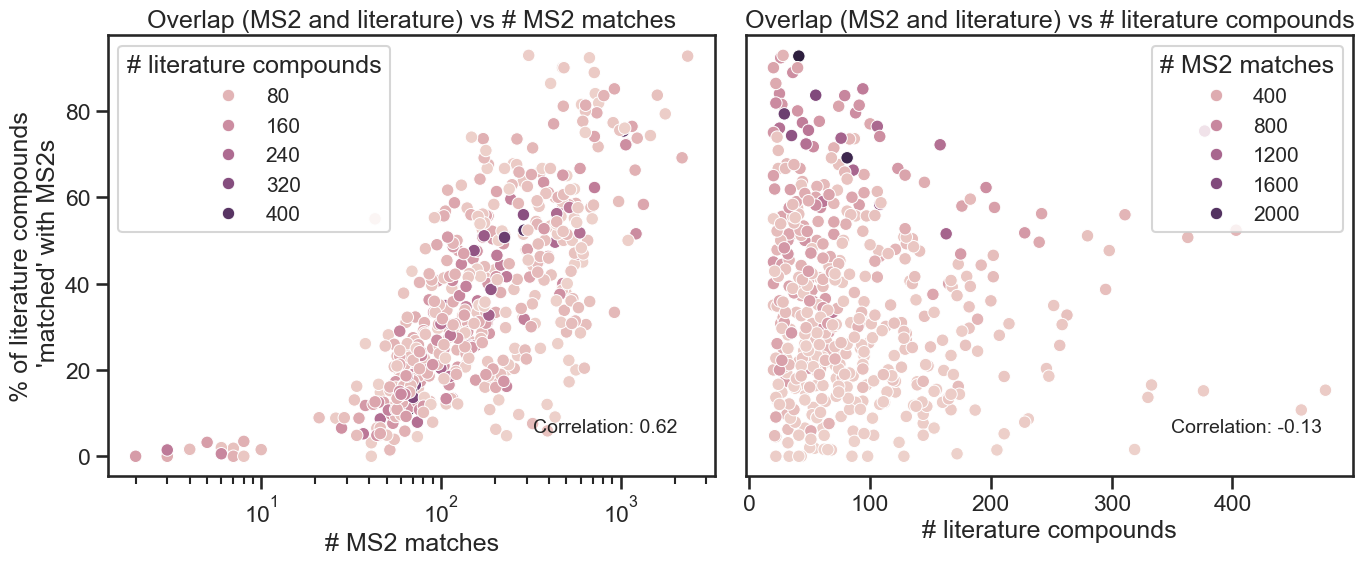

In [26]:
# Make 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(
    x="ms2_matches",
    y="ratio",
    data=plant_overlap_df,
    hue="literature_compounds",
    ax=axs[0],
)
axs[0].set_xscale("log")

axs[0].set_title("Overlap (MS2 and literature) vs # MS2 matches")
axs[0].set_xlabel("# MS2 matches")
axs[0].set_ylabel("% of literature compounds\n 'matched' with MS2s")

correlation = plant_overlap_df[["ms2_matches", "ratio"]].corr().iloc[0, 1]
axs[0].annotate(
    f"Correlation: {correlation:.2f}",
    xy=(0.7, 0.1),
    xycoords="axes fraction",
    fontsize=14,
)

# make legend font smaller
axs[0].legend(title="# literature compounds", fontsize="small")

sns.scatterplot(
    x="literature_compounds",
    y="ratio",
    data=plant_overlap_df,
    hue="ms2_matches",
    ax=axs[1],
)

axs[1].set_title("Overlap (MS2 and literature) vs # literature compounds")
axs[1].set_ylabel("")
axs[1].set_xlabel("# literature compounds")
axs[1].set_yticks([])

correlation = plant_overlap_df[["literature_compounds", "ratio"]].corr().iloc[0, 1]

axs[1].annotate(
    f"Correlation: {correlation:.2f}",
    xy=(0.7, 0.1),
    xycoords="axes fraction",
    fontsize=14,
)

axs[1].legend(title="# MS2 matches", fontsize="small")

plt.tight_layout()

plt.show()

As expected, the larger the number of MS2 spectra, the larger the overlap between the literature and the ENPKG data. However, the number of literature metabolites is not correlated with the overlap between the literature and the ENPKG data (MS2).

Let's look at the cumulative curve for plants with multiple extracts

In [27]:
extracts_per_species_curves = []

for species, subset_df in enpkg_df.groupby("wikidata_species_id"):

    if subset_df["file_name"].nunique() <= 5:
        continue

    subset_df = subset_df[subset_df["adduct"] == "[M+H]+"]

    subset_df["rounded_precursor_mz"] = [
        round(mz, 2) for mz in subset_df["precursor_mz"]
    ]

    counts = []

    current_set = set()

    baseline = None

    # for filename
    for i, (_, filename_df) in enumerate(subset_df.groupby("file_name")):

        if i == 0:
            baseline = set(filename_df["rounded_precursor_mz"].unique())

        # Keep all species the same length
        if i > 5:
            continue

        # get the rounded precursor mz
        precursor_mzs_in_sample = set(filename_df["rounded_precursor_mz"].unique())

        # and update the cumulative set
        current_set.update(precursor_mzs_in_sample)
        # store the length of the cumulative set divided by the baseline
        counts.append(len(current_set) / len(baseline))

    extracts_per_species_curves.append(
        {
            "species": wikidata_dict[species],
            "counts": counts,
        }
    )

extracts_per_species_curves = pd.DataFrame(extracts_per_species_curves)

Make Figure 3 for the paper

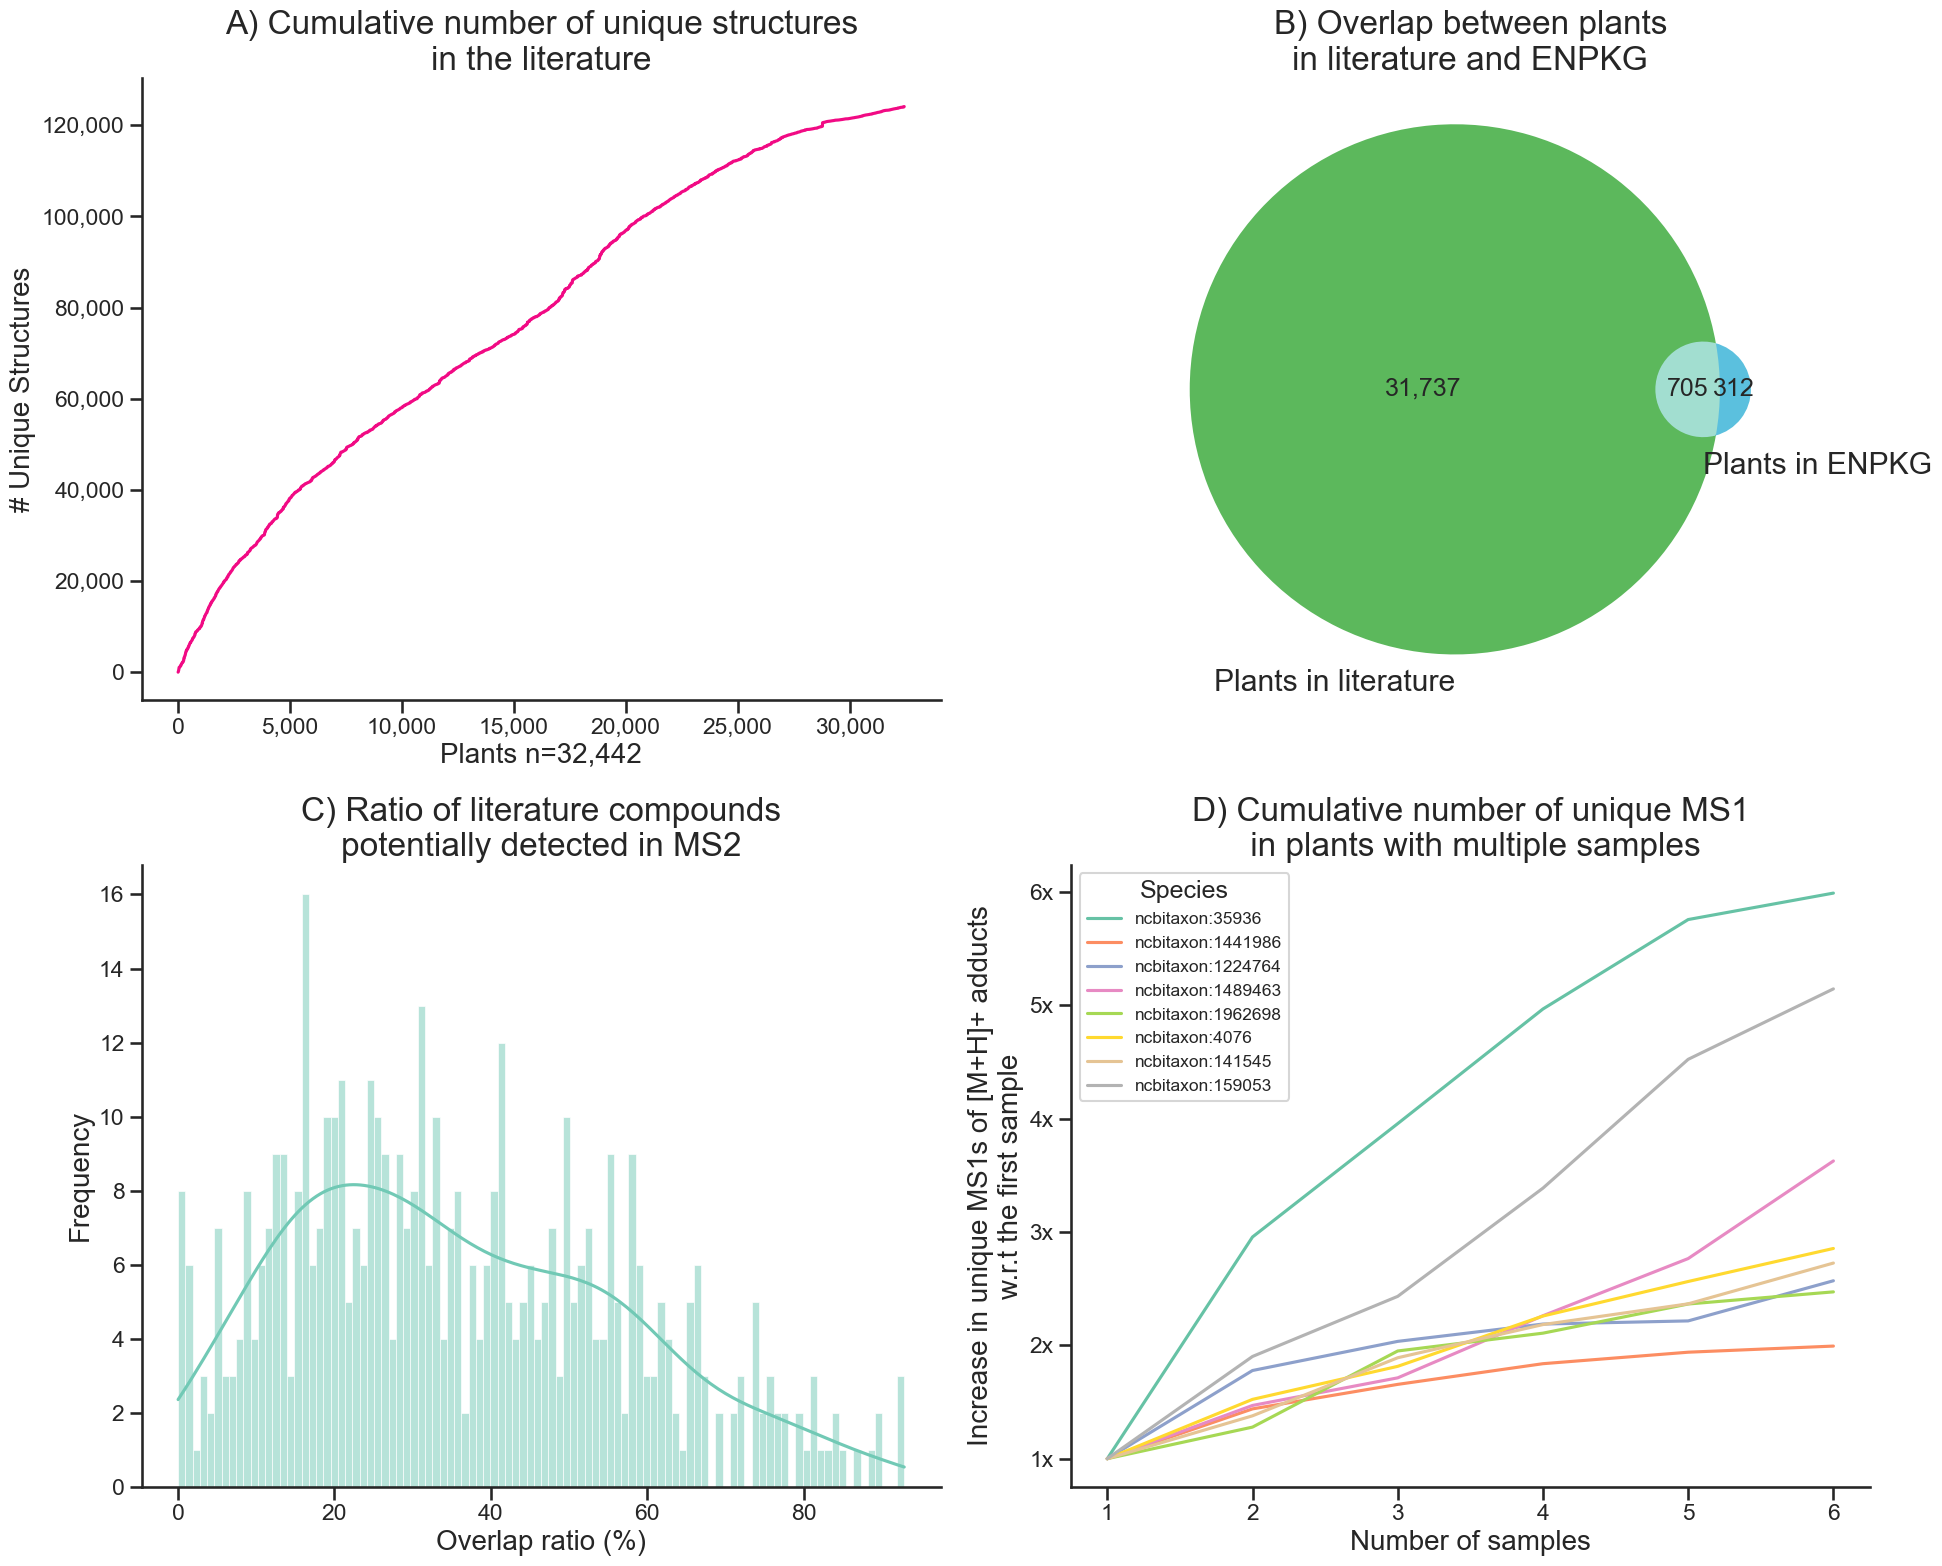

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(20, 16))

# A) Number of unique structures in the literature
sns.lineplot(
    y="cumulative_structures",
    x="mapped_curie",
    data=compounds_in_plant,
    color="#F10A84",
    ax=ax[0][0],
)

# thousands with commas on Y axis
ax[0][0].get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

ax[0][0].set_title(
    "A) Cumulative number of unique structures\nin the literature", fontsize=24
)

ax[0][0].set_xlabel(
    f"Plants n={compounds_in_plant.mapped_curie.nunique():,}", fontsize=20
)
ax[0][0].set_ylabel("# Unique Structures", fontsize=20)

ax[0][0].get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

# B) Venn diagram of plants in literature and ENPKG

diagram = venn2(
    subsets=[
        set(literature_df.mapped_curie.unique()),
        set(enpkg_df.mapped_curie.unique()),
    ],
    set_labels=("Plants in literature", "Plants in ENPKG"),
    ax=ax[0][1],
)

diagram.get_patch_by_id("10").set_color("#5cb85c")
diagram.get_patch_by_id("10").set_alpha(1.0)

diagram.get_patch_by_id("11").set_color("#a2ded0")
diagram.get_patch_by_id("11").set_alpha(1.0)
diagram.get_patch_by_id("01").set_color("#5bc0de")
diagram.get_patch_by_id("01").set_alpha(1.0)

for text in diagram.subset_labels:
    text.set_fontsize(18)
    # modify text to have a comma for thousands
    text.set_text(f"{int(text.get_text()):,}")

ax[0][1].set_title("B) Overlap between plants\nin literature and ENPKG", fontsize=24)

# C) Distribution of the ratio of literature compounds potentially detected in MS2
sns.histplot(
    plant_overlap_df["ratio"],
    bins=100,
    kde=True,
    color="#71c9b5",
    ax=ax[1][0],
)

ax[1][0].set_title(
    "C) Ratio of literature compounds\npotentially detected in MS2", fontsize=24
)

ax[1][0].set_ylabel("Frequency", fontsize=20)
ax[1][0].set_xlabel("Overlap ratio (%)", fontsize=20)

# D) Cumulative number of MS1 in plants with multiple samples

colors = sns.color_palette("Set2")

for i, row in extracts_per_species_curves.iterrows():
    ax[1][1].plot(row["counts"], label=row["species"], color=colors[i])

ax[1][1].set_xticks(range(6))

# Replace the zero with one in the labels
tick_labels = [str(i + 1) for i in range(6)]
ax[1][1].set_xticklabels(tick_labels)

ax[1][1].set_title(
    "D) Cumulative number of unique MS1\n in plants with multiple samples", fontsize=24
)
ax[1][1].set_xlabel("Number of samples", fontsize=20)
ax[1][1].set_ylabel(
    "Increase in unique MS1s of [M+H]+ adducts\nw.r.t the first sample", fontsize=20
)

ax[1][1].legend(title="Species", fontsize="x-small")

# Make Y axis with "1x", "2x", "3x" etc
ax[1][1].set_yticklabels([f"{i}x" for i in range(0, 8)])

sns.despine()

plt.tight_layout()

plt.savefig("../figures/figure_3.png", dpi=600)

plt.show()